In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Generating our dataset

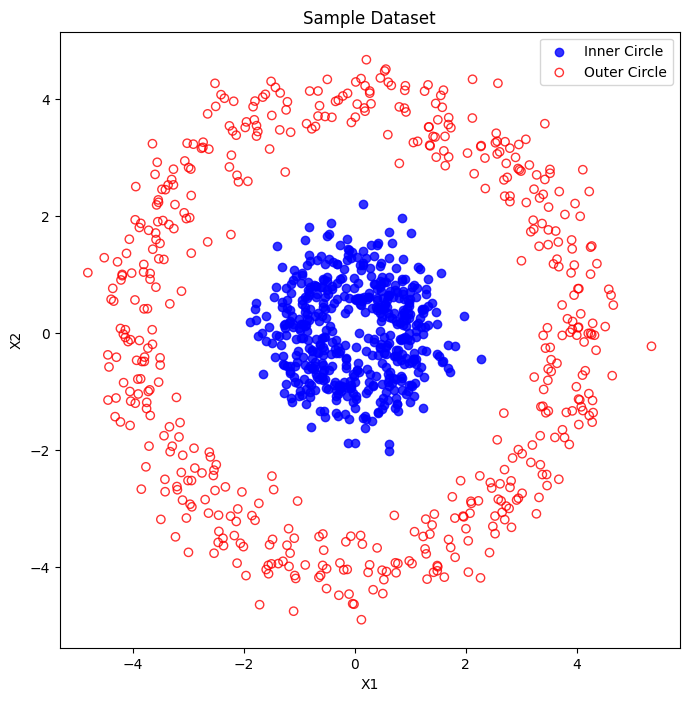

In [23]:
num_samples = 500
inner_radius = 1
outer_radius = 4
noise_level = 0.4

# Generate inner circle data with noise
theta_inner = np.linspace(0, 2*np.pi, num_samples)
x_inner = inner_radius * np.cos(theta_inner) + np.random.normal(0, noise_level, size=num_samples)
y_inner = inner_radius * np.sin(theta_inner) + np.random.normal(0, noise_level, size=num_samples)
labels_inner = np.zeros(num_samples)

# Generate outer circle data with noise
theta_outer = np.linspace(0, 2*np.pi, num_samples)
x_outer = outer_radius * np.cos(theta_outer) + np.random.normal(0, noise_level, size=num_samples)
y_outer = outer_radius * np.sin(theta_outer) + np.random.normal(0, noise_level, size=num_samples)
labels_outer = np.ones(num_samples)

# Concatenate data
X = np.concatenate([np.column_stack([x_inner, y_inner]), np.column_stack([x_outer, y_outer])])
y = np.concatenate([labels_inner, labels_outer])

# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(x_inner, y_inner, color='blue', label='Inner Circle', alpha=0.8)
plt.scatter(x_outer, y_outer, facecolors='none', edgecolors='red', label='Outer Circle', alpha=0.8)
plt.title('Sample Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()


## Neural Net and Training

In [60]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4) 
        self.fc3 = nn.Linear(4, 1)
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [62]:
# Instantiate the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
with torch.no_grad():
    model.eval()
    predicted = model(X_test_tensor)
    predicted_labels = (predicted.squeeze() > 0.5).float()  # Convert probabilities to binary labels
    accuracy = (predicted_labels == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy:.2f}')

Epoch [100/1000], Loss: 0.7046
Epoch [200/1000], Loss: 0.6394
Epoch [300/1000], Loss: 0.5658
Epoch [400/1000], Loss: 0.4509
Epoch [500/1000], Loss: 0.3270
Epoch [600/1000], Loss: 0.2247
Epoch [700/1000], Loss: 0.1601
Epoch [800/1000], Loss: 0.1187
Epoch [900/1000], Loss: 0.0905
Epoch [1000/1000], Loss: 0.0706
Test Accuracy: 1.00


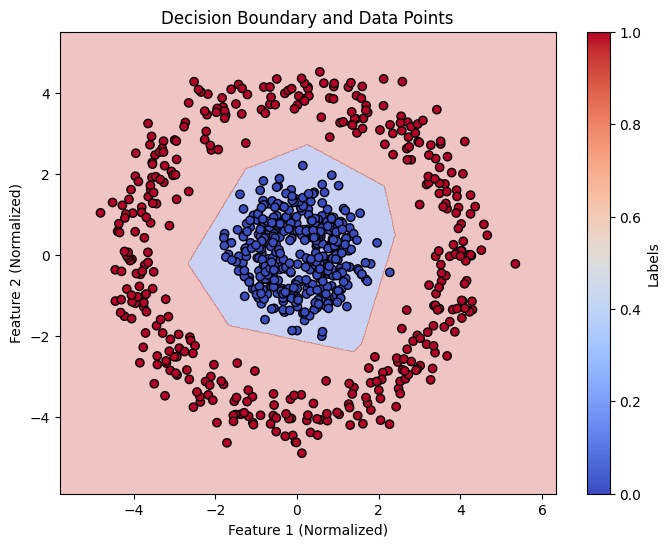

In [64]:
from sklearn.preprocessing import StandardScaler

# Function to create mesh grid
def create_meshgrid(X, h=.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


# Create mesh grid
xx, yy = create_meshgrid(X_train)

# Flatten the mesh grid points and predict their labels
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_points_tensor = torch.tensor(mesh_points, dtype=torch.float32)
with torch.no_grad():
    model.eval()
    preds = model(mesh_points_tensor)
    preds = (preds > 0.5).float().numpy().reshape(xx.shape)

# Plot decision boundary and data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, preds, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title('Decision Boundary and Data Points')
plt.xlabel('Feature 1 (Normalized)')
plt.ylabel('Feature 2 (Normalized)')
plt.colorbar(label='Labels')
plt.show()

## Now let's see the mode's output layer by layer

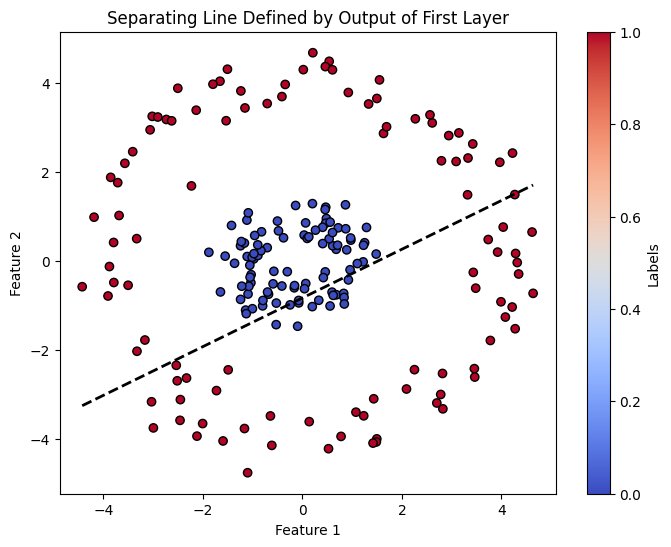

In [68]:
def get_outputs(model, X):
    out1 = model.fc1(X)
    out1_relu = torch.relu(out1)
    out2 = model.fc2(out1_relu)
    out2_relu = torch.relu(out2)
    out3 = model.fc3(out2_relu)
    out3_sigmoid = torch.sigmoid(out3)
    return out1_relu, out2_relu, out3_sigmoid


# Get outputs of the first layer for test data
with torch.no_grad():
    model.eval()
    out1_test, _, _ = get_outputs(model, X_test_tensor)

# Extract weights and biases from the first layer
weights = model.fc1.weight.data.numpy()
biases = model.fc1.bias.data.numpy()

# Plot the data points and the separating line defined by the output of the first layer
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k')

# Plot the separating line
x_values = np.linspace(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 100)
y_values = (-weights[0, 0] / weights[0, 1]) * x_values - biases[0] / weights[0, 1]
plt.plot(x_values, y_values, color='black', linestyle='--', linewidth=2)

plt.title('Separating Line Defined by Output of First Layer')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Labels')
plt.show()

## Generating heatmap of the output of each layer

In [108]:
plt.style.use(['dark_background'])

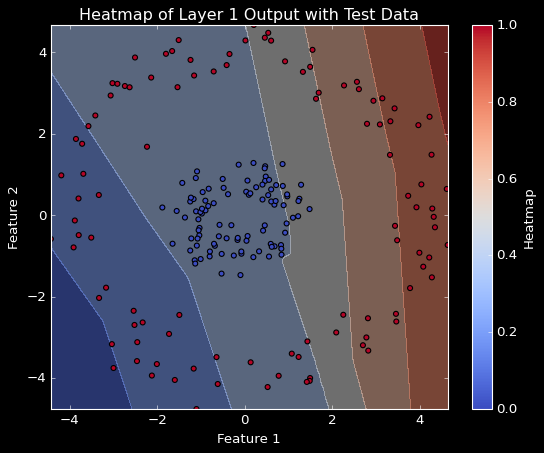

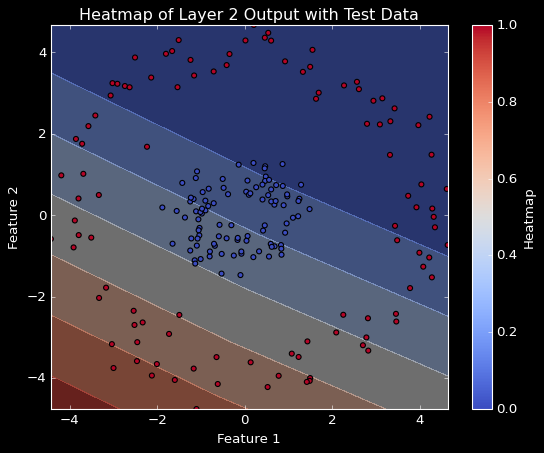

In [109]:
def get_hidden_layer_output(model, layer_idx, input_data):
    """Function to get the output of a specific hidden layer in the model."""
    # Get all the layers in the model
    layers = list(model.children())
    
    # Iterate through the layers until the desired hidden layer
    for layer in layers[:layer_idx]:
        input_data = layer(input_data)
    
    # Return the output of the desired hidden layer
    output = input_data
    return output

# Create a meshgrid to cover the entire feature space
xx, yy = np.meshgrid(np.linspace(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 100),
                     np.linspace(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 100))

# Flatten and concatenate the mesh grid points
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Convert mesh points to tensor
mesh_points_tensor = torch.tensor(mesh_points, dtype=torch.float32)

# Iterate through each hidden layer
for i in range(2):
    # Create a new plot for each layer
    plt.figure(figsize=(8, 6))

    # Compute the output of the current hidden layer using the test data
    with torch.no_grad():
        model.eval()
        output = get_hidden_layer_output(model, i+1, X_test_tensor)

    # Apply ReLU activation function to the output
    output_relu = torch.relu(output)

    # Reduce the dimensionality of the output to 1 dimension
    pca = PCA(n_components=1)
    output_reduced = pca.fit_transform(output_relu.numpy())

    # Compute the output of the current hidden layer for mesh grid points
    with torch.no_grad():
        model.eval()
        hidden_output_mesh = get_hidden_layer_output(model, i+1, mesh_points_tensor)

    # Apply ReLU activation function to the output
    hidden_output_mesh_relu = torch.relu(hidden_output_mesh)

    # Reduce the dimensionality of the output to 1 dimension
    hidden_output_reduced = pca.transform(hidden_output_mesh_relu.numpy())

    # Reshape output to the shape of mesh grid
    output_grid = hidden_output_reduced.reshape(xx.shape)

    # Plot heatmap of the output of the current hidden layer
    plt.contourf(xx, yy, output_grid, cmap='coolwarm', alpha=0.5)

    # Plot dataset points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k')

    # Add colorbar and labels
    plt.colorbar(label='Heatmap')
    plt.title(f'Heatmap of Layer {i+1} Output with Test Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()